<a href="https://colab.research.google.com/github/irnikesh/data-science/blob/main/neural-network-and-deep-learning/5_deep_computer_vision_with_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Computer Vision Using Convolutional Neural Networks

#Setup


This project requires Python 3.7 or above:

In [7]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [8]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [9]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier:

In [10]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [11]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
# IS_KAGGLE = "kaggle_secrets" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    # if IS_KAGGLE:
    #     print("Go to Settings > Accelerator and select GPU.")

# Convolutional Layers
## Implementing Convolutional Layers With Keras

Let's load two sample images, rescale their pixel values to 0-1, and center crop them to small 70×120 images:

In [1]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

In [2]:
images.shape # 4D tensor: 2 sample images, 70*120, each pixel holds value per color channel (RGB)

TensorShape([2, 70, 120, 3])

In [4]:
tf.random.set_seed(42)
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

In [5]:
fmaps.shape

TensorShape([2, 64, 114, 32])

hight and width both shrunk by 6 pixels (since 7 kernel size), because Conv2D does not use zero-padding by default

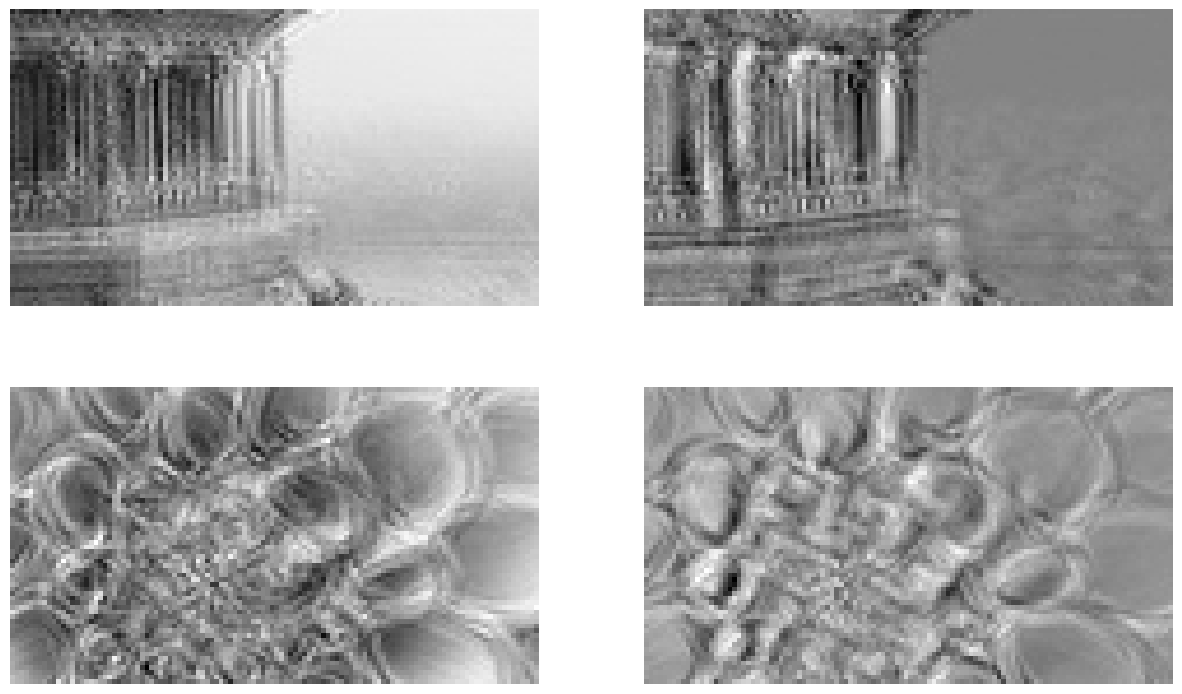

In [12]:
# displays the two output feature maps for each image
plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

As you can see, randomly generated filters typically act like edge detectors, which is great since that's a useful tool in image processing, and that's the type of filters that a convolutional layer typically starts with. Then, during training, it gradually learns improved filters to recognize useful patterns for the task.

Now let's use zero-padding:

In [14]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,
                                    padding="same")
fmaps = conv_layer(images)

In [15]:
fmaps.shape

TensorShape([2, 70, 120, 32])

In [16]:
# the output shape when we set strides=2
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same",
                                    strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [17]:
# this utility function can be useful to compute the size of the
# feature maps output by a convolutional layer. It also returns
# the number of ignored rows or columns if padding="valid", or the
# number of zero-padded rows or columns if padding="same"."""

import numpy as np

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")

(array([35, 60]), array([5, 5]))

Let's now look at the weights:

In [18]:
kernels, biases = conv_layer.get_weights()
kernels.shape # [kernel_height, kernel_width, input_channels, output_channels]

(7, 7, 3, 32)

In [19]:
biases.shape # output_channels - number of filters

(32,)

In [21]:
# shows how to use the tf.nn.conv2d() operation

tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases